# Imports

In [2]:
from sklearn import model_selection
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, RidgeCV, HuberRegressor, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from lightgbm import LGBMRegressor
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Analyse des données

In [3]:
#Récupération du dataset initial
data = pd.read_parquet(Path('data') / 'train.parquet')
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662


### Merging external data

In [4]:
#Pour visualisation et tests

__file__ = Path('submissions') /  'my_submission' /  'estimator.py'


file_path = Path(__file__).parent / 'external_data.csv'
df_ext = pd.read_csv(file_path, parse_dates=['date'], na_values="")
    
db = data.copy()
# When using merge_asof left frame need to be sorted
db['orig_index'] = np.arange(db.shape[0])
ext_cols = ['date', 't', 'ww', 'isHoliday', 'td', 'ff', 'season', 'u']
db = pd.merge_asof(db.sort_values('date'), df_ext[ext_cols].sort_values('date'), on='date')

# Sort back to the original order
db = db.sort_values('orig_index')
del db['orig_index']
del db['counter_id']
del db['site_id']
del db['counter_installation_date']
del db['counter_technical_id']

db.loc[:, 'year'] = db['date'].dt.year
db.loc[:, 'month'] = db['date'].dt.month
db.loc[:, 'day'] = db['date'].dt.day
db.loc[:, 'weekday'] = db['date'].dt.weekday
db.loc[:, 'hour'] = db['date'].dt.hour

db['workingday'] = db['weekday'].item==5 or db['weekday'].item==6 or db['isHoliday']==True

db['ww'] = db['ww'].replace(0, np.nan)
#db['ww_cor'] = db['ww']//10
db['rainingday'] = db['ww']>19

del db['date']
del db['ww']

db

,counter_name,site_name,bike_count,latitude,longitude,log_bike_count,t,isHoliday,td,ff,season,u,year,month,day,weekday,hour,workingday,rainingday
107,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,275.15,False,273.55,1.7,autumn,89,2020,9,1,1,2,False,False
157,28 boulevard Diderot E-O,28 boulevard Diderot,1.0,48.846028,2.375429,0.693147,275.15,False,273.55,1.7,autumn,89,2020,9,1,1,3,False,False
193,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,275.15,False,273.55,1.7,autumn,89,2020,9,1,1,4,False,False
769,28 boulevard Diderot E-O,28 boulevard Diderot,4.0,48.846028,2.375429,1.609438,275.15,False,273.55,1.7,autumn,89,2020,9,1,1,15,False,False
959,28 boulevard Diderot E-O,28 boulevard Diderot,9.0,48.846028,2.375429,2.302585,275.15,False,273.55,1.7,autumn,89,2020,9,1,1,18,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453515,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,51.0,48.839770,2.301980,3.951244,293.05,True,283.15,4.1,summer,53,2021,8,8,6,18,True,False
453934,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,1.0,48.839770,2.301980,0.693147,292.95,False,283.65,0.6,summer,55,2021,8,9,0,2,False,False
454316,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,61.0,48.839770,2.301980,4.127134,290.45,False,284.95,2.7,summer,70,2021,8,9,0,8,False,False
454411,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,44.0,48.839770,2.301980,3.806662,296.25,False,286.95,3.0,summer,56,2021,8,9,0,10,False,False


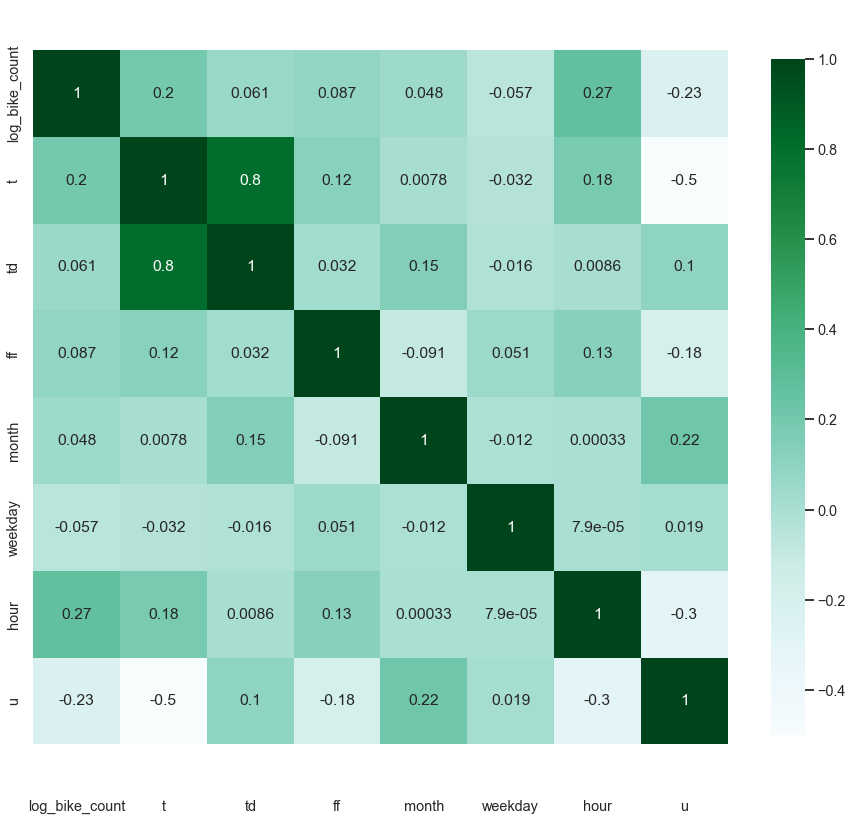

In [5]:
#Affichage de la matrice de corrélation pour les features numériques
corr_db = db[['log_bike_count', 't', 'td', 'ff', 'month', 'weekday', 'hour', 'u']].corr()

w = 16
h = 16
d = 70
sns.set( context='talk', style='whitegrid', font_scale=0.9) 
plt.figure(figsize=(w, h), dpi=d)
ax = sns.heatmap(corr_db, annot=True, square=True, cbar_kws={"shrink": .8}, cmap='BuGn')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

On observe une corrélation intéressante entre le nombre de vélo et l'humidité (u) et la température (t).

La corrélation avec la vitesse du vent (ff) est cependant moins évidente.

In [7]:
cols = ['season', 'year', 'hour', 'month', 'weekday', 'isHoliday', 'workingday', 'rainingday']

for col in cols:
    db[col] = db[col].astype('category')
db[['month', 'hour', 'weekday']] = db[['month', 'hour', 'weekday']].astype('int')
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 107 to 454785
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   counter_name    455163 non-null  category
 1   site_name       455163 non-null  category
 2   bike_count      455163 non-null  float64 
 3   latitude        455163 non-null  float64 
 4   longitude       455163 non-null  float64 
 5   log_bike_count  455163 non-null  float64 
 6   t               455163 non-null  float64 
 7   isHoliday       455163 non-null  category
 8   td              455163 non-null  float64 
 9   ff              455163 non-null  float64 
 10  season          455163 non-null  category
 11  u               455163 non-null  int64   
 12  year            455163 non-null  category
 13  month           455163 non-null  int32   
 14  day             455163 non-null  int64   
 15  weekday         455163 non-null  int32   
 16  hour            455163 non-null  int

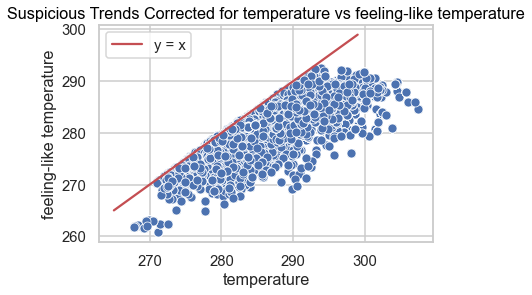

In [56]:
#Observation de la température ressentie en fonction de la température absolue
#Repérage de potentiels outliers

fig = plt.figure()
colorPalette = ['violet', 'orange', 'cyan']
g = sns.scatterplot(x='t', y='td', data=db,
                      palette=colorPalette,
                     legend=False)
g.set_title('Suspicious Trends Corrected for temperature vs feeling-like temperature',
             color="black")
plt.xlabel('temperature')
plt.ylabel('feeling-like temperature')
plt.plot(np.arange(265, 300), np.arange(265, 300), color='r', label='y = x')
plt.legend()
plt.show()

An interesting issue would be to apply a PCA on those two parameters in order to reduce the dimension to one and but to keep more informations.

### Trends visualization

[262.04912306  13.44322803  15.62282084   2.3624284    6.66387646
  25.53443492   0.4041629    3.05046763   0.66879338]


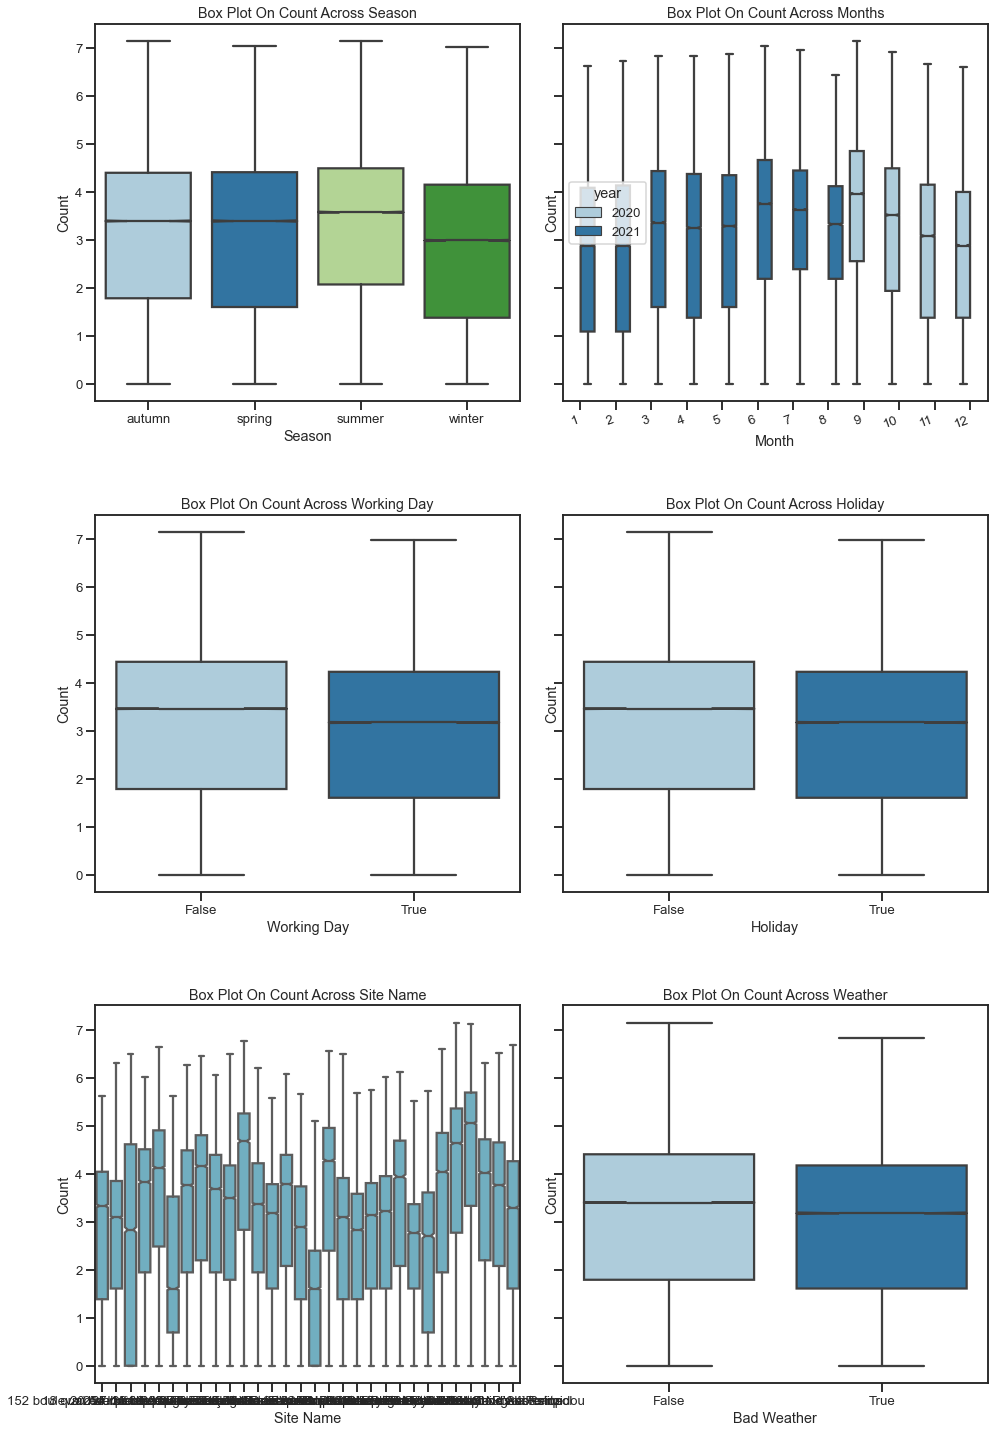

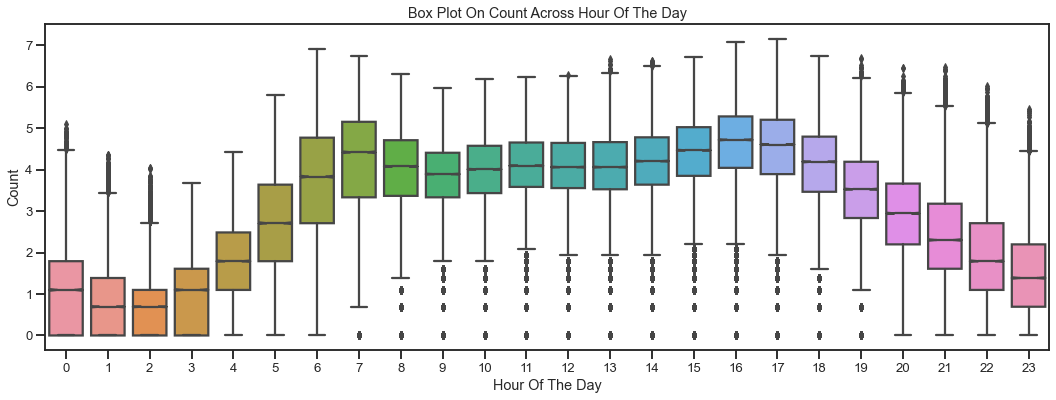

In [57]:
sns.set(context='talk', style='ticks', font_scale=0.8, palette="Paired")
fig, axes = plt.subplots(nrows=3,ncols=2, sharey=True, figsize=(16,25))
fig.subplots_adjust(hspace=0.3, wspace=0.10)


sns.boxplot(y="log_bike_count",x="season", data=db, orient="v", notch=True, ax=axes[0][0])
g = sns.boxplot(y="log_bike_count",x="month", data=db, orient="v", hue='year', notch=True, ax=axes[0][1])
plt.setp(g.get_xticklabels(), rotation=20, ha="right")
sns.boxplot(y="log_bike_count",x="workingday", data=db, orient="v", notch=True, ax=axes[1][0])
sns.boxplot(y="log_bike_count",x="isHoliday", data=db, orient="v", notch=True, ax=axes[1][1])
sns.boxplot(y="log_bike_count",x="site_name", data=db, orient="v", notch=True, ax=axes[2][0], color='c')
sns.boxplot(y="log_bike_count",x="rainingday", data=db, orient="v", notch=True, ax=axes[2][1])


axes[0][0].set(xlabel='Season', ylabel='Count', title="Box Plot On Count Across Season")
axes[0][1].set(xlabel='Month', ylabel='Count', title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][1].set(xlabel='Holiday', ylabel='Count', title="Box Plot On Count Across Holiday")
axes[2][0].set(xlabel='Site Name', ylabel='Count', title="Box Plot On Count Across Site Name")
axes[2][1].set(xlabel='Bad Weather', ylabel='Count', title="Box Plot On Count Across Weather")

#Calcul du nombre de données par catégorie

noofobs = db.groupby(['ww_cor']).size()
print(np.array(noofobs)/455163*365)


sns.set(context='talk', style='ticks', font_scale=0.8,palette="Paired")
fig, axes = plt.subplots(nrows=1,ncols=1, sharey=True, figsize=(18,6))
sns.boxplot(y="log_bike_count",x="hour", data=db, orient="v", notch=True, ax=axes)
axes.set(xlabel='Hour Of The Day', ylabel='Count', title="Box Plot On Count Across Hour Of The Day")
plt.show()
plt.close('all')

[Text(0.5, 1.0, 'Count of bikes during weekdays and weekends'),
 Text(0, 0.5, 'Log Bike Count')]

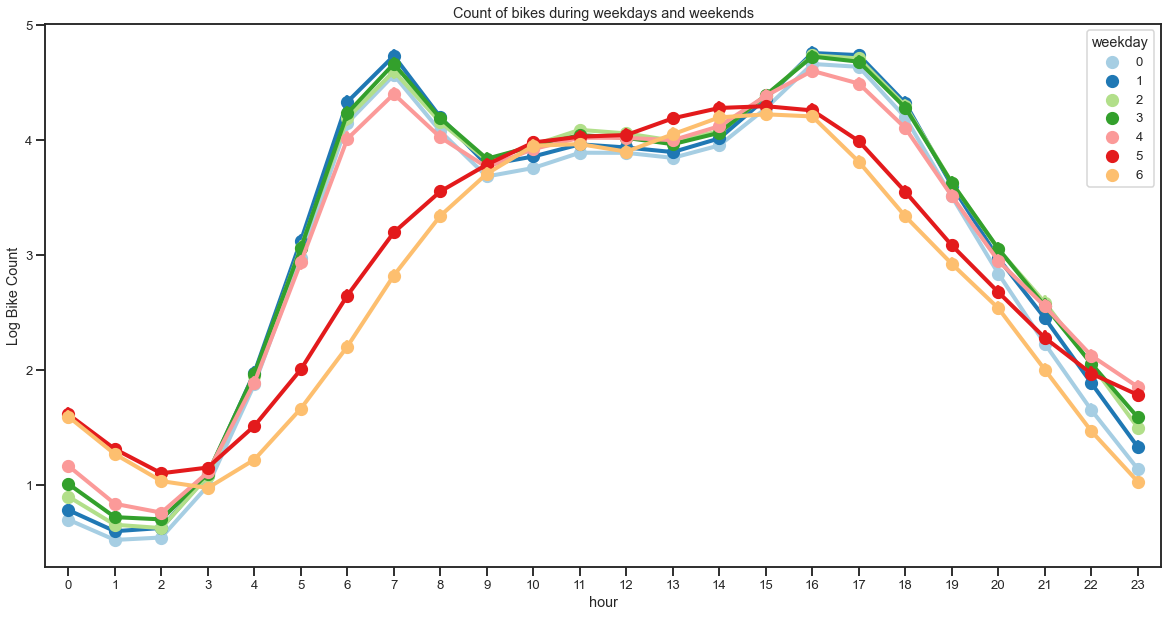

In [68]:
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=db, x='hour', y='log_bike_count', hue='weekday', ax=ax)
ax.set(title='Count of bikes during weekdays and weekends', ylabel='Log Bike Count')

# Enconding

In [64]:
cols = ['season', 'year', 'hour', 'month', 'weekday', 'isHoliday', 'workingday', 'rainingday', 'counter_name', 'site_name']

for col in cols:
    db = pd.concat([db, pd.get_dummies(db[col], prefix=col, drop_first=True)], axis=1)
db.head()

,counter_name,site_name,bike_count,latitude,longitude,log_bike_count,t,isHoliday,td,ff,...,site_name_Pont de Bercy,site_name_Pont de la Concorde S-N,site_name_Pont des Invalides N-S,site_name_Pont des Invalides S-N,site_name_Quai d'Orsay,site_name_Totem 64 Rue de Rivoli,site_name_Totem 73 boulevard de Sébastopol,site_name_Totem 85 quai d'Austerlitz,site_name_Totem Cours la Reine,site_name_Voie Georges Pompidou
107,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,275.15,False,273.55,1.7,...,0,0,0,0,0,0,0,0,0,0
157,28 boulevard Diderot E-O,28 boulevard Diderot,1.0,48.846028,2.375429,0.693147,275.15,False,273.55,1.7,...,0,0,0,0,0,0,0,0,0,0
193,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,275.15,False,273.55,1.7,...,0,0,0,0,0,0,0,0,0,0
769,28 boulevard Diderot E-O,28 boulevard Diderot,4.0,48.846028,2.375429,1.609438,275.15,False,273.55,1.7,...,0,0,0,0,0,0,0,0,0,0
959,28 boulevard Diderot E-O,28 boulevard Diderot,9.0,48.846028,2.375429,2.302585,275.15,False,273.55,1.7,...,0,0,0,0,0,0,0,0,0,0


In [40]:
pca=PCA(n_components=1)
pca.fit(db[['t', 'td']])
db['temperature']=pca.fit_transform(db[['t', 'td']])

print(f" Variance explained after PCA : {pca.explained_variance_ratio_}")

 Variance explained after PCA : [0.90505895]


In [41]:
def sin_transformer(period, dba):
    return  np.sin(dba / period * 2 * np.pi)


def cos_transformer(period, dba):
    return  np.cos(dba / period * 2 * np.pi)

In [42]:

db["hour_sin"] = sin_transformer(24, db["hour"])
db["hour_cos"] = cos_transformer(24, db["hour"])

db["month_sin"] = sin_transformer(12, db["month"])
db["month_cos"] = cos_transformer(12, db["month"])

db["weekday_sin"] = sin_transformer(7, db["weekday"])
db["weekday_cos"] = cos_transformer(7, db["weekday"])

db.head()

,counter_name,site_name,bike_count,latitude,longitude,log_bike_count,t,isHoliday,td,ff,...,hour,workingday,rainingday,hour_sin,month_sin,weekday_sin,hour_cos,month_cos,weekday_cos,temperature
107,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,275.15,False,273.55,1.7,...,2,False,False,0.500000,-1.0,0.781831,8.660254e-01,-1.836970e-16,0.62349,12.193176
157,28 boulevard Diderot E-O,28 boulevard Diderot,1.0,48.846028,2.375429,0.693147,275.15,False,273.55,1.7,...,3,False,False,0.707107,-1.0,0.781831,7.071068e-01,-1.836970e-16,0.62349,12.193176
193,28 boulevard Diderot E-O,28 boulevard Diderot,0.0,48.846028,2.375429,0.000000,275.15,False,273.55,1.7,...,4,False,False,0.866025,-1.0,0.781831,5.000000e-01,-1.836970e-16,0.62349,12.193176
769,28 boulevard Diderot E-O,28 boulevard Diderot,4.0,48.846028,2.375429,1.609438,275.15,False,273.55,1.7,...,15,False,False,-0.707107,-1.0,0.781831,-7.071068e-01,-1.836970e-16,0.62349,12.193176
959,28 boulevard Diderot E-O,28 boulevard Diderot,9.0,48.846028,2.375429,2.302585,275.15,False,273.55,1.7,...,18,False,False,-1.000000,-1.0,0.781831,-1.836970e-16,-1.836970e-16,0.62349,12.193176


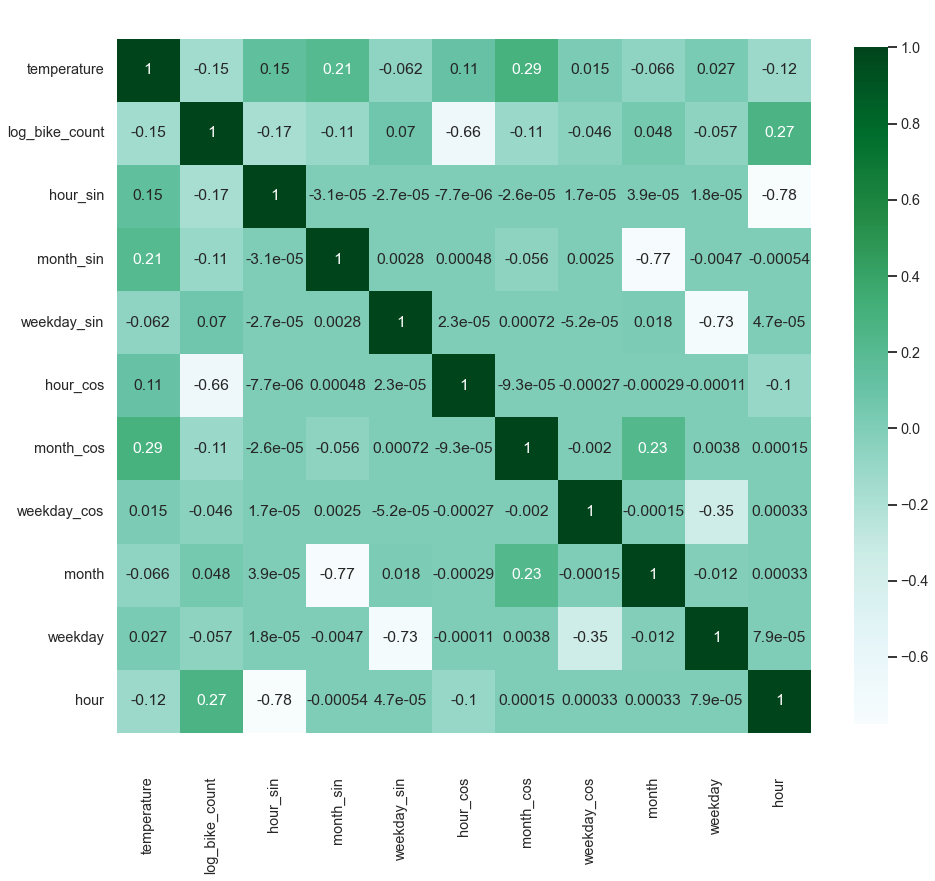

In [43]:
#Affichage de la matrice de corrélation après transformation
corr_db = db[['temperature', 'log_bike_count', "hour_sin", "month_sin", "weekday_sin","hour_cos", "month_cos", "weekday_cos", 'month', 'weekday', 'hour']].corr()

w = 16
h = 16
d = 70
sns.set( context='talk', style='whitegrid', font_scale=0.9) 
plt.figure(figsize=(w, h), dpi=d)
ax = sns.heatmap(corr_db, annot=True, square=True, cbar_kws={"shrink": .8}, cmap='BuGn')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Train and test set creation

In [88]:
r_2 = []
RMSE = []

In [98]:
X = db.drop(['season', 'temperature',  'counter_name', 'site_name', 'bike_count', 'month', 'hour', 'weekday', 'day', 'log_bike_count'], axis=1)
y = db['log_bike_count']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [117]:
model = LGBMRegressor()

t = time.time()
model.fit(X_train,y_train)
alg_y_pred = model.predict(X_test)
RMSE.append(np.sqrt(mean_squared_error(y_test,alg_y_pred)))
r_2.append(r2_score(y_test,alg_y_pred))
print("R_squared = "+ str(r_2))
print("RMSE = " + str(RMSE))
print("Durée : " + str(float(time.time())-float(t)) + " s")

#best with t, season, longitude, latitude importante

R_squared = [0.9053006377594245, 0.9068079965292185, 0.9061440056487228, 0.9070842385871297, 0.9070842385871297, 0.9070842385871297, 0.943867922482501]
RMSE = [0.5153813887815545, 0.5112631936490629, 0.5130813300977577, 0.5105048817336697, 0.5105048817336697, 0.5105048817336697, 0.39679004025784226]
Durée : 749.431955575943 s


Le PCA n'a pas d'intérêt si ce n'est un gain de temps.

# Visualisation models RMSE 

In [86]:
import time

In [105]:
models = [RidgeCV(), HistGradientBoostingRegressor(max_depth=50), LGBMRegressor(), RandomForestRegressor(max_depth=50)]
model_names = ['RidgeCV', 'HistGradientBoostingRegressor()','LGBMRegressor', 'RandomForestRegressor']
rmse = []
r_squared = []
dic = {}
for model in range (len(models)):
    t = time.time()
    alg = models[model]
    alg.fit(X_train,y_train)
    alg_y_pred = alg.predict(X_train)
    rmse.append(np.sqrt(mean_squared_error(y_train,alg_y_pred)))
    r_squared.append(r2_score(y_train,alg_y_pred))
    print(r_squared)
    print(rmse)
    print("durée : " + str(time.time()-t) + " s")
dic={'Modelling Algorithms':model_names,'RMSE':rmse,'R-Squared':r_squared}   
model_performances = pd.DataFrame(dic)

model_performances

C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\base.py:561: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


[0.7754069052741056]
[0.7938890081423348]
durée : 7.451195240020752 s
[0.7754069052741056, 0.9082447010533726]
[0.7938890081423348, 0.507431199600001]
durée : 20.24467134475708 s
[0.7754069052741056, 0.9082447010533726, 0.9079779426156872]
[0.7938890081423348, 0.507431199600001, 0.5081682868027415]
durée : 4.540301561355591 s
[0.7754069052741056, 0.9082447010533726, 0.9079779426156872, 0.9919996403807498]
[0.7938890081423348, 0.507431199600001, 0.5081682868027415, 0.14983605972587974]
durée : 711.0424716472626 s


,Modelling Algorithms,RMSE,R-Squared
0,RandomForestRegressor,0.793889,0.775407
1,RidgeCV,0.507431,0.908245
2,HistGradientBoostingRegressor(),0.508168,0.907978
3,LGBMRegressor,0.149836,0.992000


In [106]:
rmse

[0.7938890081423348,
 0.507431199600001,
 0.5081682868027415,
 0.14983605972587974]

In [111]:
rmse=[0.7938890081423348, 0.507431199600001, 0.5081682868027415, 0.14983605972587974]
y=['RidgeCV', 'HistGradientBoostingRegressor()','LGBMRegressor', 'RandomForestRegressor']

Text(0.5, 1.0, 'RMSE of tested algorithms')

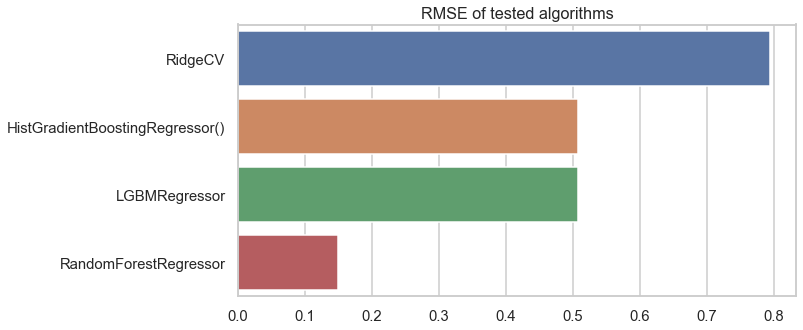

In [112]:
plt.figure(figsize = (10,5))
#sns.barplot(x='Modelling Algorithms',y='RMSE',data=model_performances)
sns.barplot(x=rmse, y=y)
plt.title("RMSE of tested algorithms")

RandomForestRegressor est le plus intéressant mais très lent à excécuter, l'objectif va être de voir s'il est possible d'améliorer suffisamment LGBMRegressor pour avoir un RMSE plus faible que RandomForest.

# Test LGBM

In [113]:
model=LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.67, importance_type='split',
              learning_rate=0.03, max_bin=55, max_depth=-1,
              min_child_samples=160, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1500, n_jobs=-1, num_leaves=200, objective=None,
              random_state=18, reg_alpha=0.23,
              reg_lambda=0.34, subsample=0.57, subsample_for_bin=200000,
              subsample_freq=1)

In [114]:
t = time.time()
model.fit(X_train, y_train)
print(str(model.score(X_test, y_test)))
print(str(time.time()-t))

0.9504024302358927

In [115]:
y_mod = model.predict(X_test)

In [116]:
np.sqrt(mean_squared_error(y_test,y_mod))

0.37297987822891676

# Hyperparameters tuning

In [2]:
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score

In [118]:
# A sample parameter
parameters = {'n_estimators': [100, 155],
              'max_depth'    : [40, 55],
              'min_samples_split' : [3, 5],
              'max_features' : ['auto']

            }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(LGBMRegressor(), parameters,scoring='neg_mean_squared_error',refit=False,cv=2, n_jobs=-1)

clf.fit(X, y)
#converting the clf.cv_results to dataframe
clf.best_params_

ValueError: Found input variables with inconsistent numbers of samples: [455163, 4]

In [57]:
clf.best_score_

-0.8957883614735904

## Code final

In [22]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [23]:
def _select_data(X):
    X=X.copy()
    drop_cols = ['counter_name', 'site_name', 'counter_installation_date', 'counter_technical_id', 'latitude', 'longitude']
    X.drop(columns=drop_cols)
    return X

In [24]:
__file__ = Path('submissions') /  'my_submission' /  'estimator.py'


def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    X['workingday'] = X['weekday'].item==5 or X['weekday'].item==6 or X['isHoliday']==True
    X['rainingday'] = X['ww']>19
    X = X.drop(columns=["ww"])
    
    cols = ['season', 'day', 'year', 'isHoliday', 'workingday', 'rainingday', 'counter_name', 'site_name']

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    

In [25]:
def _merge_external_data(X):
    
    ext_cols = ['date', 't', 'ww', 'isHoliday', 'td', 'season', 'u', 'ff']
    
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    # Là on peut choisir plus de données dans la base de données météo
    X = pd.merge_asof(X.sort_values('date'), df_ext[ext_cols].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    
    pca=PCA(n_components=1)
    X['temperature']=pca.fit_transform(X[['t', 'td']])
    #X.drop(['t', 'td'], axis=1)
    return(X)

In [26]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [10]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

date_encoder = FunctionTransformer(_encode_dates)
merge_data = FunctionTransformer(_merge_external_data, validate=False)
date_cols = ['year', 'day']
numeric_cols = ['temperature', 'u']

categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_cols = ["counter_name", 'site_name', "counter_id", "site_id", "rainingday", "isHoliday", "season", "workingday", "year"]

preprocessor = ColumnTransformer(
        [
        ("date", OneHotEncoder(handle_unknown="ignore", sparse=False), date_cols),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
        ("cat", categorical_encoder, categorical_cols),
        ('numeric', 'passthrough', numeric_cols)
        ]
    )
pipel = [merge_data,date_encoder, preprocessor]
for encoder in pipel :
    X_train = encoder.fit_transform(X_train)
    X_test = encoder.transform(X_test)

    
    # A sample parameter
parameters = {'learning_rate': [ 0.8],
            'max_iter': [1000],
            'min_samples_leaf': [300],
            'max_depth': [47]
            }

#tscv = model_selection.TimeSeriesSplit(n_splits=4)
#passing the scoring function in the GridSearchCV
#tscv.split(X_train)
clf = GridSearchCV(HistGradientBoostingRegressor(), parameters,scoring='r2',refit=False,cv=2, n_jobs=1)

clf.fit(X_train, y_train)
#converting the clf.cv_results to dataframe
print(str(clf.best_params_))

print(f'Test set, RMSE={mean_squared_error(y_test, clf.predict(X_test), squared=False):.2f}')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



{'learning_rate': 0.8, 'max_depth': 47, 'max_iter': 1000, 'min_samples_leaf': 300}
Traceback (most recent call last):
  File "C:\Users\pierr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pierr\AppData\Local\Temp/ipykernel_12548/3449824470.py", line 48, in <module>
    print(f'Test set, RMSE={mean_squared_error(y_test, clf.predict(X_test), squared=False):.2f}')
  File "C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 109, in __get__
    if not self.check(obj):
  File "C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 370, in check
    _check_refit(self, attr)
  File "C:\Users\pierr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 351, in _check_refit
    f"This {type(search_cv).__name__} instance was initialized with "
AttributeError: This GridSearchCV instance was initialized with `refit=F

TypeError: object of type 'NoneType' has no len()

0.631 : 0.5 - - 15 - 47 - times 2

0.698 : 0.5 - - 15 - 47 - times 4

0.662 : 0.5--15-47 - not times

0.700 : 0.5--40-47

0.699 : 0.8--100-47

In [138]:
clf.best_score_

0.6495200790508779

In [62]:
def get_estimator():
    date_encoder = FunctionTransformer(_encode_dates)
    merge_data = FunctionTransformer(_merge_external_data, validate=False)
    #data_selector = FunctionTransformer(_select_data)
    date_cols = ['year', 'day']
    numeric_cols = ['temperature', 'u']

    categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    #categorical_encoder = OrdinalEncoder()

    categorical_cols = ["counter_id", "site_id", "rainingday", "isHoliday", "season", "workingday", "year"]

    
    preprocessor = ColumnTransformer(
        [
        ("date", OneHotEncoder(handle_unknown="ignore", sparse=False), date_cols),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
        ("cat", categorical_encoder, categorical_cols),
        ('numeric', 'passthrough', numeric_cols)
        ]
    )
    #regressor = GradientBoostingRegressor(learning_rate=0.09, n_estimators=500, max_depth=4)
    #regressor = RidgeCV()
    #regressor = DecisionTreeRegressor(max_depth=47, max_features='sqrt', max_leaf_nodes=150000)
    regressor = HistGradientBoostingRegressor(max_depth=47, learning_rate=0.4, max_iter=300, min_samples_leaf=100)

    pipe = make_pipeline(merge_data, date_encoder, preprocessor, regressor)

    return pipe

## Test du modèle

In [63]:
pipe = get_estimator()

In [64]:
pipe.fit(X_train, y_train)
print('done')

done


In [65]:
pipe.score(X_test, y_test)

0.8914244952169467

In [66]:
print(f'Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}')
print(f'Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}')

Train set, RMSE=0.38
Test set, RMSE=0.47


## Résultats

### Données supplémentaires : Température uniquement

HistGradientBoostingRegressor(random_state=0) : 
Train set, RMSE=0.53 ||
Test set, RMSE=0.52

Ridge() + OrdinalEncoder() : 
Train set, RMSE=1.54 ||
Test set, RMSE=1.31

Ridge() + OneHotEncoder() :
Train set, RMSE=1.40 ||
Test set, RMSE=1.11
